<a href="https://colab.research.google.com/github/660710078/TopGun2025/blob/main/Pre2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setup & Installation

In [ ]:
# ติดตั้ง libraries ที่จำเป็น
!pip install ultralytics
!pip install opencv-python-headless
!pip install numpy pandas matplotlib

# Import libraries
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import math

# Mount Google Drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


Step 2: Dataset Setup

In [ ]:
# กำหนด path
base_path = '/content/drive/MyDrive/drone_dataset'
yaml_path = f'{base_path}/data.yaml'

# ตรวจสอบโครงสร้าง dataset
!ls -la {base_path}

total 9
-rw------- 1 root root  113 Oct 27 04:37 data.yaml
drwx------ 2 root root 4096 Oct 27 03:59 train
drwx------ 2 root root 4096 Oct 27 03:59 valid


Step 3: Train YOLOv8 Model

In [ ]:
# โหลด YOLOv8 model
model = YOLO('yolov8n.pt')  # n=nano, s=small, m=medium, l=large, x=xlarge

# Train model
results = model.train(
    data=yaml_path,
    epochs=50,  # ปรับตามความต้องการ
    imgsz=640,
    batch=16,
    name='drone_detection',
    patience=10,  # Early stopping
    save=True,
    plots=True
)

# บันทึก trained model
model.save(f'{base_path}/best_drone_model.pt')

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/drone_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=drone_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspect

In [30]:
# โหลด best model หลังเทรนเสร็จ
best_model_path = '/content/runs/detect/drone_detection/weights/best.pt'
model = YOLO(best_model_path)

In [31]:
# ประเมินผลบน validation set
val_metrics = model.val(data=yaml_path, split='val')

# แสดงผล metric
print(f"   mAP50:     {val_metrics.box.map50:.4f}")
print(f"   mAP50-95:  {val_metrics.box.map:.4f}")
print(f"   Precision: {val_metrics.box.mp:.4f}")
print(f"   Recall:    {val_metrics.box.mr:.4f}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.6 ms, read: 15.9±15.1 MB/s, size: 188.3 KB)
val: Scanning /content/drive/MyDrive/drone_dataset/valid/labels.cache... 347 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 347/347 344.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 1.8it/s 12.1s
                   all        347        369      0.936      0.856      0.932      0.569
Speed: 2.4ms preprocess, 3.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/runs/detect/val3
   mAP50:     0.9321
   mAP50-95:  0.5694
   Precision: 0.9363
   Recall:    0.8564


In [33]:
def detect_drones_image(image_path, save_path='result.jpg', conf=0.5, iou=0.45):
    """
    ตรวจจับ drone ในรูปภาพเดียว

    Args:
        image_path: path ของรูปภาพ
        save_path: path สำหรับบันทึกผลลัพธ์
        conf: confidence threshold (0-1)
        iou: IoU threshold for NMS

    Returns:
        num_drones: จำนวน drone
        drone_info: ข้อมูล drone แต่ละตัว
    """
    # Predict
    results = model.predict(
        source=image_path,
        conf=conf,
        iou=iou,
        save=False,
        verbose=False
    )

    # draw bounding box
    annotated = results[0].plot()

    # ดึงข้อมูล bounding boxes
    boxes = results[0].boxes
    num_drones = len(boxes)

    drone_info = []

    for i, box in enumerate(boxes):
        # พิกัด (xyxy format)
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

        # center
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # conf
        confidence = box.conf[0].cpu().numpy()

        # Class (drone = 0)
        cls = int(box.cls[0].cpu().numpy())

        # เก็บข้อมูล
        drone_info.append({
            'id': i + 1,
            'class': cls,
            'center': (int(center_x), int(center_y)),
            'bbox': (int(x1), int(y1), int(x2), int(y2)),
            'confidence': float(confidence),
            'width': int(x2 - x1),
            'height': int(y2 - y1),
            'area': int((x2 - x1) * (y2 - y1))
        })

        # draw center
        cv2.circle(annotated, (int(center_x), int(center_y)), 8, (0, 255, 0), -1)
        cv2.circle(annotated, (int(center_x), int(center_y)), 10, (0, 0, 255), 2)

        # add text
        text = f"Drone #{i+1}"
        cv2.putText(annotated, text, (int(center_x)+15, int(center_y)-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # พิกัดจุดกึ่งกลาง
        coord_text = f"({int(center_x)}, {int(center_y)})"
        cv2.putText(annotated, coord_text, (int(center_x)+15, int(center_y)+10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Confidence
        conf_text = f"{confidence:.2%}"
        cv2.putText(annotated, conf_text, (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # ใส่สรุปที่มุมบนซ้าย
    summary_text = f"Drones Detected: {num_drones}"
    cv2.rectangle(annotated, (5, 5), (400, 50), (0, 0, 0), -1)
    cv2.putText(annotated, summary_text, (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # บันทึก
    cv2.imwrite(save_path, annotated)

    # แสดงผล
    print(f"\n{'='*60}")
    print(f"Detection result: {os.path.basename(image_path)}")
    print(f"{'='*60}")
    print(f"Founded drone: {num_drones}\n")

    for info in drone_info:
        print(f"Drone #{info['id']}:")
        print(f"  └─ centroid: {info['center']}")
        print(f"  └─ Bounding Box: {info['bbox']}")
        print(f"  └─ size: {info['width']} x {info['height']} px")
        print(f"  └─ area: {info['area']} px²")
        print(f"  └─ Conf: {info['confidence']:.2%}\n")

    # แสดงใน Colab
    display(Image(filename=save_path))

    return num_drones, drone_info


Detection result: drones.png
Founded drone: 4

Drone #1:
  └─ centroid: (1299, 393)
  └─ Bounding Box: (1230, 343, 1367, 443)
  └─ size: 136 x 99 px
  └─ area: 13542 px²
  └─ Conf: 87.42%

Drone #2:
  └─ centroid: (155, 455)
  └─ Bounding Box: (77, 398, 232, 512)
  └─ size: 155 x 114 px
  └─ area: 17746 px²
  └─ Conf: 85.62%

Drone #3:
  └─ centroid: (450, 489)
  └─ Bounding Box: (394, 450, 506, 529)
  └─ size: 111 x 78 px
  └─ area: 8835 px²
  └─ Conf: 85.43%

Drone #4:
  └─ centroid: (870, 513)
  └─ Bounding Box: (836, 488, 904, 537)
  └─ size: 67 x 48 px
  └─ area: 3315 px²
  └─ Conf: 80.34%



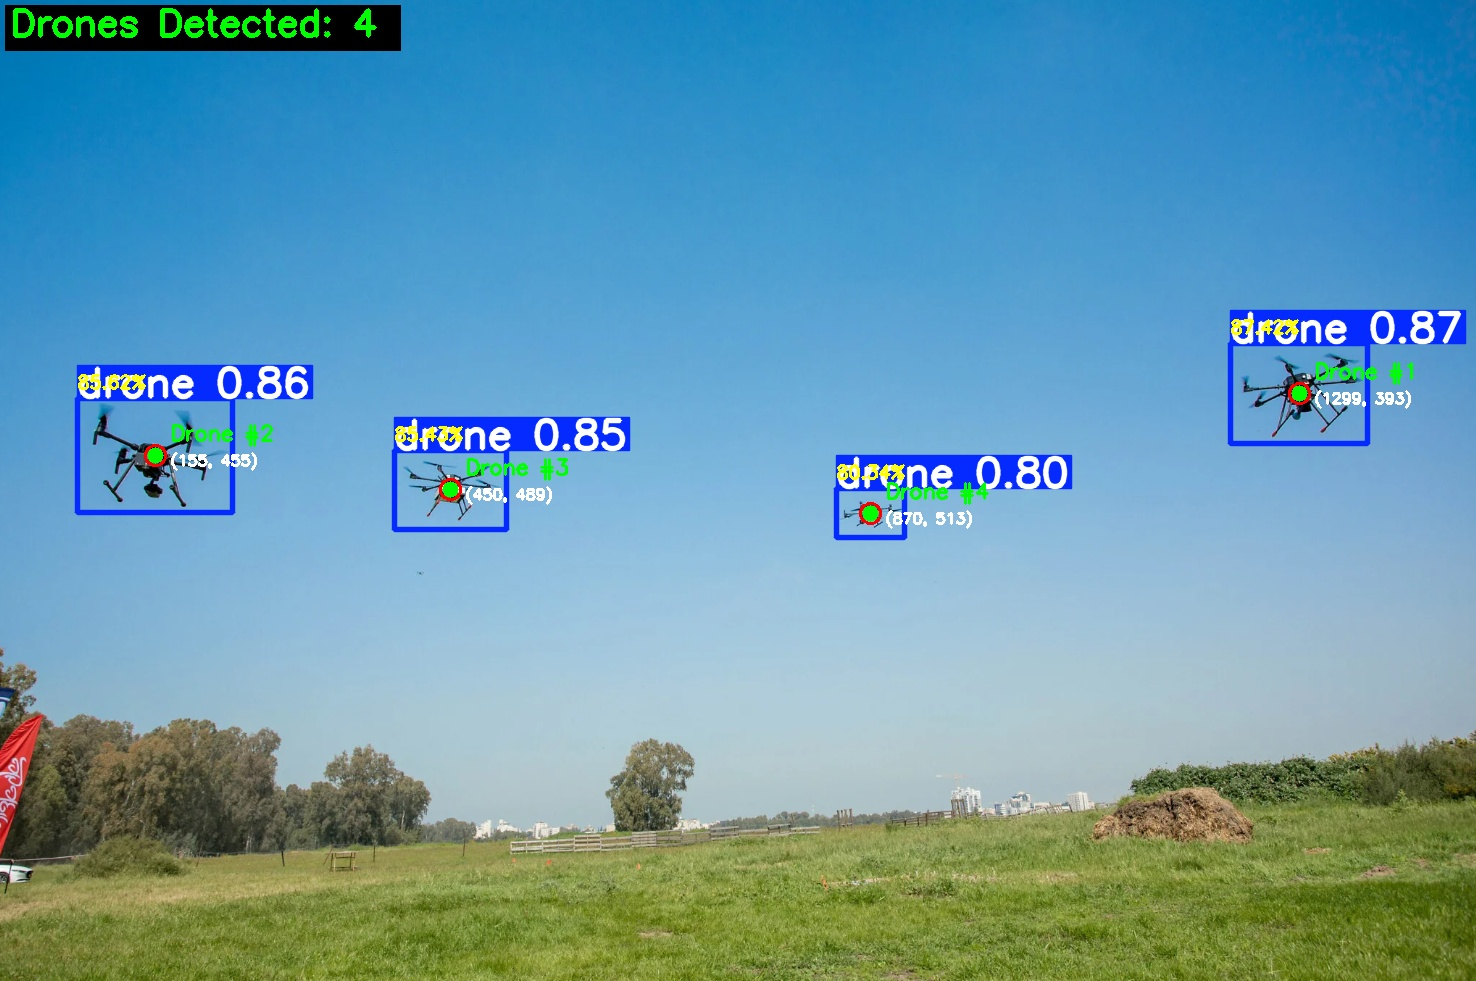

(4,
 [{'id': 1,
   'class': 0,
   'center': (1299, 393),
   'bbox': (1230, 343, 1367, 443),
   'confidence': 0.8742396235466003,
   'width': 136,
   'height': 99,
   'area': 13542},
  {'id': 2,
   'class': 0,
   'center': (155, 455),
   'bbox': (77, 398, 232, 512),
   'confidence': 0.8561882376670837,
   'width': 155,
   'height': 114,
   'area': 17746},
  {'id': 3,
   'class': 0,
   'center': (450, 489),
   'bbox': (394, 450, 506, 529),
   'confidence': 0.8542804718017578,
   'width': 111,
   'height': 78,
   'area': 8835},
  {'id': 4,
   'class': 0,
   'center': (870, 513),
   'bbox': (836, 488, 904, 537),
   'confidence': 0.8033715486526489,
   'width': 67,
   'height': 48,
   'area': 3315}])

In [34]:
detect_drones_image('/content/drones.png', 'result1.jpg')

In [35]:

def detect_drones_video(video_path, output_path='output_video.mp4', conf=0.5):
    """
    ตรวจจับ drone ในวิดีโอ

    Args:
        video_path: path ของวิดีโอ
        output_path: path สำหรับบันทึกวิดีโอผลลัพธ์
        conf: confidence threshold

    Returns:
        output_path: path ของวิดีโอที่บันทึก
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"can't open thi video: {video_path}")
        return None

    # video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"\nVideo info:")
    print(f"  FPS: {fps}")
    print(f"  frame size: {width}x{height}")
    print(f"  frame num: {total_frames}")

    # create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    drone_count_per_frame = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Predict
        results = model(frame, conf=conf, verbose=False)

        # draw bounding box
        annotated = results[0].plot()

        # find drone centroid
        boxes = results[0].boxes
        num_drones = len(boxes)
        drone_count_per_frame.append(num_drones)

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            # draw centroid
            cv2.circle(annotated, (center_x, center_y), 8, (0, 255, 0), -1)
            cv2.circle(annotated, (center_x, center_y), 10, (0, 0, 255), 2)

            # put drone ID
            cv2.putText(annotated, f"#{i+1}", (center_x+15, center_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # show text info in video
        info_text = [
            f"Frame: {frame_count + 1}/{total_frames}",
            f"Drones: {num_drones}",
        ]

        y_offset = 30
        for text in info_text:
            cv2.putText(annotated, text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            y_offset += 40

        # put frame count text
        out.write(annotated)
        frame_count += 1

        # show progress
        if frame_count % 30 == 0 or frame_count == total_frames:
            progress = (frame_count / total_frames) * 100
            print(f"  progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")

    cap.release()
    out.release()

    # summary
    avg_drones = sum(drone_count_per_frame) / len(drone_count_per_frame) if drone_count_per_frame else 0
    max_drones = max(drone_count_per_frame) if drone_count_per_frame else 0

    print(f"\nVideo processing complete")
    print(f"  saved at: {output_path}")
    print(f"  drone avg: {avg_drones:.2f} per frame")
    print(f"  max drone: {max_drones} per frame")

    return output_path

In [36]:
detect_drones_video('/content/VDO_Test.mp4', 'output_video.mp4')


Video info:
  FPS: 29
  frame size: 1920x1080
  frame num: 408
  progress: 30/408 frames (7.4%)
  progress: 60/408 frames (14.7%)
  progress: 90/408 frames (22.1%)
  progress: 120/408 frames (29.4%)
  progress: 150/408 frames (36.8%)
  progress: 180/408 frames (44.1%)
  progress: 210/408 frames (51.5%)
  progress: 240/408 frames (58.8%)
  progress: 270/408 frames (66.2%)
  progress: 300/408 frames (73.5%)
  progress: 330/408 frames (80.9%)
  progress: 360/408 frames (88.2%)
  progress: 390/408 frames (95.6%)
  progress: 408/408 frames (100.0%)

Video processing complete
  saved at: output_video.mp4
  drone avg: 5.75 per frame
  max drone: 9 per frame


'output_video.mp4'

In [37]:
import requests

url = 'https://example.com/data.json'
try:
    r = requests.get(url)
    r.raise_for_status()  # check error
    data = r.json()
    print(data)
except Exception as e:
    print("Error:", e)


Error: 404 Client Error: Not Found for url: https://example.com/data.json
